 what's different from 05.07:
 - Run with more recent charging point data
 - Fix charging rate for viz of power

In [3]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats
from scipy.stats import norm

# import plotly.plotly as py
# import plotly.tools as tls
# import plotly.graph_objs as go

from sklearn import datasets, linear_model
import copy

# import EV_chargingstation_planning_inputdata_l2 as ECPinput
# import cvxpy as cvx
import pdb

In [4]:
def load_chargePoint_data(filename, wantzero=True):
    """
        Load charge point data into python
        filename - string, specify file name
        wantzero - boolean, specify if want to keep zero energy sessions in data
    """
    
    df = pd.read_csv(filename)
    # Columns of information that exists in the csv file
    print("dataframe column: ")
    print(df.columns)
    
    # Extract columns that we are interested in
    cp_df = df[["MAC Address", "Start Date", "End Date", "User ID", "Energy (kWh)", 
                "Port Type", "Total Duration (hh:mm:ss)", "Charging Time (hh:mm:ss)"]]
    
    cp_len = len(cp_df)
    if not wantzero:
        
        # Delete zero entries
        cp_df = cp_df[(cp_df != 0).all(1)]
        print("\n")
        print("Deleted {} zero entries.".format(cp_len - len(cp_df)))
        
    else:
        
        # Fix NaN entries in End Date
        nan_number = 0
        for indx, row in cp_df.iterrows():
            if pd.isna(cp_df.loc[indx, "End Date"]):
                if not pd.isna(cp_df.loc[indx, "Start Date"]):

                    endDate = pd.to_datetime(cp_df.loc[indx, "Start Date"]) + \
                    pd.to_timedelta(cp_df.loc[indx, "Total Duration (hh:mm:ss)"])

                    cp_df.at[indx, "End Date"] = str(endDate)

                    nan_number += 1
        print("\n")
        print("Fixed {} NaN values".format(nan_number))
    
    return cp_df 

In [6]:
csv_file = 'chargpoint_0101_0229_2020_Data.csv'
csv_file = '../../market_participation/aggregate_model/chargpoint_LifetimeData.csv'
cp_df = load_chargePoint_data(csv_file, wantzero=False)
cp_df

dataframe column: 
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Zip/Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency',
       'Fee', 'Ended By', 'Plug In Event ID', 'Driver Zip/Postal Code',
       'User ID', 'Start SOC', 'End SOC', 'County', 'System S/N',
       'Model Number', 'OnRamp Id Tag'],
      dtype='object')


Deleted 2915 zero entries.


/Users/janton/anaconda3/envs/ev_fleet/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (30) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0004:2E93,2021-02-21 17:30:16,2021-02-21 18:18:05,601291,5.553,Level 2,00:47:50,00:47:36
1,0024:B100:0002:1280,2021-02-21 15:25:42,2021-02-21 16:44:09,20339931,8.788,Level 2,01:18:30,01:18:15
2,0024:B100:0002:1302,2021-02-21 11:30:21,2021-02-21 12:42:04,1629811,8.020,Level 2,01:11:44,01:11:25
3,0024:B100:0002:1302,2021-02-20 11:16:27,2021-02-20 12:51:15,1629811,10.682,Level 2,01:34:51,01:34:31
4,0024:B100:0004:2E93,2021-02-20 10:09:47,2021-02-20 11:14:24,601291,7.497,Level 2,01:04:40,01:04:13
...,...,...,...,...,...,...,...,...
37143,0024:B100:0002:2010,2018-05-03 14:43:16,2018-05-03 16:25:53,516687,7.001,Level 2,01:42:40,01:03:29
37144,0024:B100:0002:1280,2021-01-08 08:15:47,2021-01-09 13:37:54,2.06311e+07,3.840,Level 2,00:35:30,00:35:08
37145,0024:B100:0002:1280,2021-02-19 08:04:11,NaN,NaN,27.608,Level 2,05:50:54,04:54:15
37146,0024:B100:0002:12F1,2019-04-05 11:54:12,2019-04-05 13:21:48,378691,4.945,Level 2,01:27:40,01:27:27


# Data visualization

In [4]:
x_data_chargeTime = pd.to_timedelta(cp_df["Charging Time (hh:mm:ss)"]).dt.total_seconds()
y_data_energy = pd.to_numeric(cp_df["Energy (kWh)"])

## Charging Duration

Text(0, 0.5, 'Frequency')

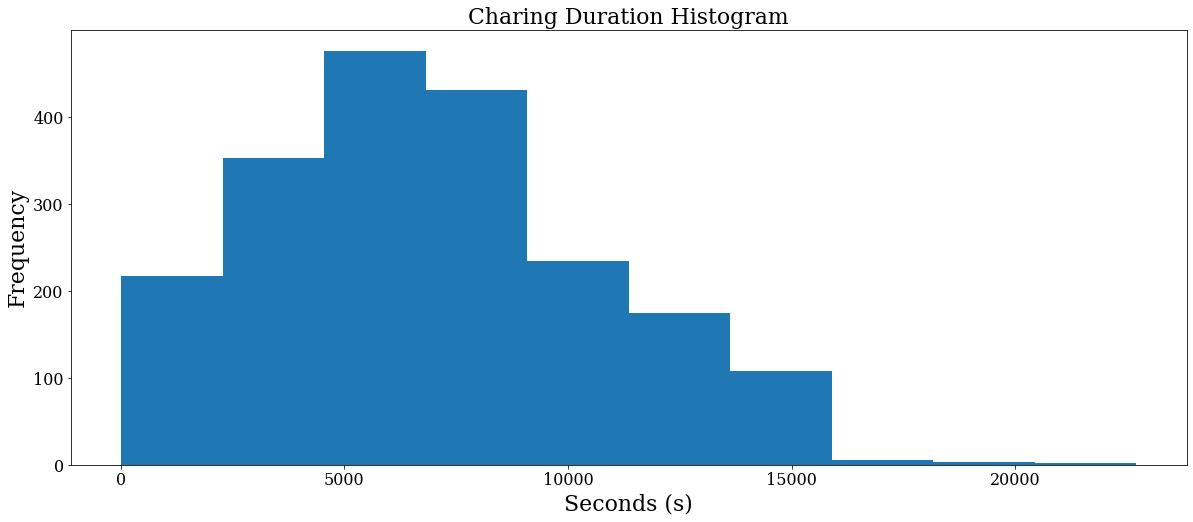

In [5]:
font = {'family' : 'serif',
        'size'   : 16}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,8))
plt.hist(x_data_chargeTime)
plt.title("Charing Duration Histogram", fontsize=22)
plt.xlabel("Seconds (s)", fontsize=22)
plt.ylabel("Frequency", fontsize=22)


# plotly_fig = tls.mpl_to_plotly( fig )
# py.iplot(plotly_fig, filename='mpl-basic-histogram')


## Session Length - Load data from CP database directly

Text(0, 0.5, 'Cumulative Percentage (%)')

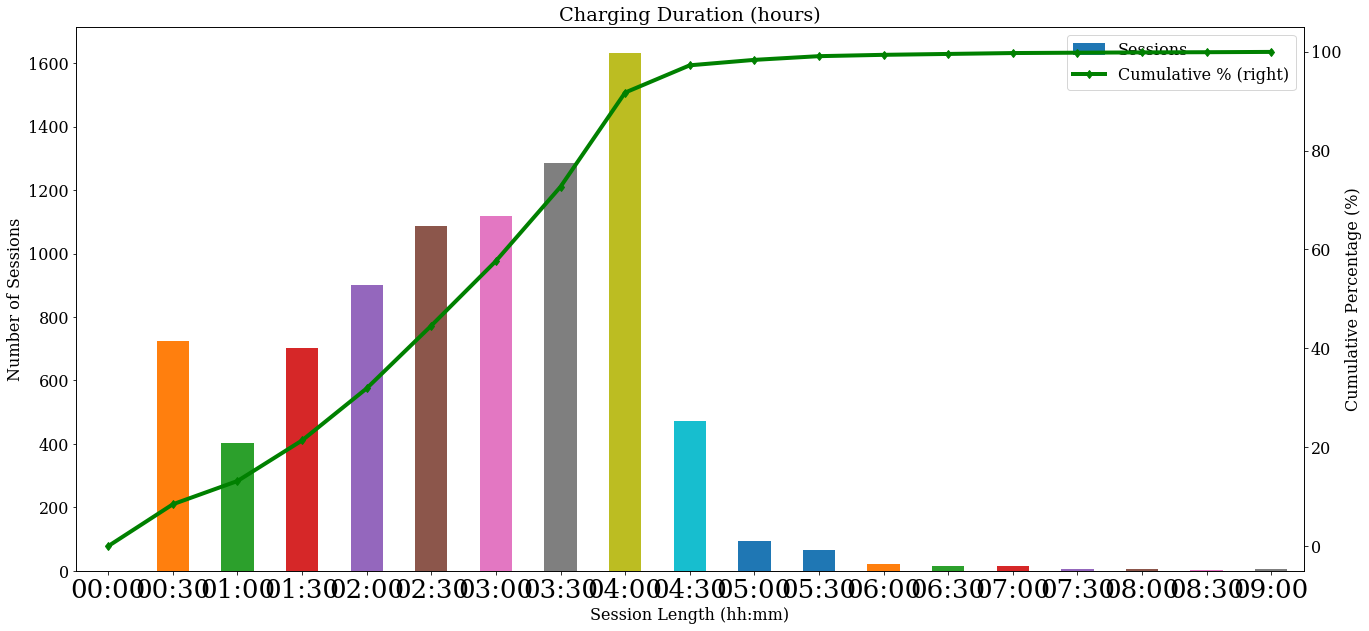

In [6]:
sl_df = pd.read_csv("session_length.csv") #plot data download directly from CP
sl_df = sl_df.iloc[:19, :]
ax = sl_df.plot.bar(x="Session Length (hh:mm)", y="Sessions", figsize=(22,10))
ax.set_xticklabels(sl_df["Session Length (hh:mm)"], fontsize=26)
ax.set_ylabel("Number of Sessions")
ax.set_title("Charging Duration (hours)")

ax2 = sl_df.plot.line(x="Session Length (hh:mm)", y="Cumulative %", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True)
ax2.set_ylabel("Cumulative Percentage (%)")
# plt.savefig("output_figures/session_length_CP.pdf")

## EV Market Shares - Essencially we need weighted average battery sizes of 7.2 and 3.6 EVs

In [7]:
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)

In [8]:
ev_sales_df

,2018,2017,2016,2015,2014,Total Sales,Charging Power (kW),Battery (kWh),Total Battery (kWh)
Tesla Model 3,13782,1764,0,0,0,15546,7.2,50.000000,7.773000e+05
Toyota Prius Prime + PHEV,27595,20936,2474,4191,13264,68460,3.6,7.674806,5.254172e+05
Tesla Model X,26100,21315,18223,214,0,65852,7.2,75.000000,4.938900e+06
Tesla Model S,25745,27060,28896,25202,16689,123592,7.2,70.000000,8.651440e+06
Honda Clarity PHEV,18602,1121,0,0,0,19723,7.2,25.500000,5.029365e+05
Chevy Volt,18306,20349,24739,15393,18805,97592,3.6,18.400000,1.795693e+06
Chevy Bolt,18019,23297,579,0,0,41895,7.2,60.000000,2.513700e+06
Nissan Leaf,14715,11230,14006,17269,30200,87420,7.2,35.000000,3.059700e+06
Ford Fusion Energi,8074,9632,15938,9750,11550,54944,3.6,7.600000,4.175744e+05
Ford C-max Energi,582,8140,7957,7591,8433,32703,3.6,7.600000,2.485428e+05


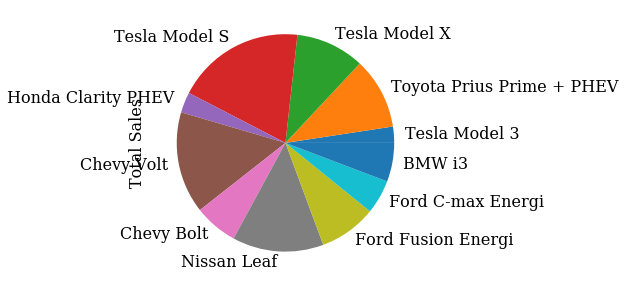

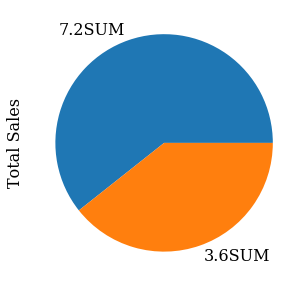

In [9]:
font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)
ev_sales_df.iloc[:-2,:].plot.pie(y="Total Sales", figsize=(5,5), legend=False)
ev_sales_df.loc[["7.2SUM", "3.6SUM"],:].plot.pie(y="Total Sales", figsize=(5,5), legend=False)

# Quantile Regression

In [10]:
x_data_chargeTime_copy = copy.deepcopy(x_data_chargeTime)
y_data_energy_copy = copy.deepcopy(y_data_energy)

x_data_chargeTime_copy = x_data_chargeTime_copy.dropna()
y_data_energy_copy = y_data_energy_copy.dropna()

x_data_chargeTime_copy = x_data_chargeTime_copy.values
y_data_energy_copy = y_data_energy_copy.values

In [11]:
font = {'family' : 'serif',
        'size'   : 20}

matplotlib.rc('font', **font)

def quantile_regression(x_data, y_data, q_list, loc, comments):
    """
        From charging rates extract quantile and perform linear regression
        x_data - numpy array
        y_data - numpy array
        q_list - list of quantiles, [0, 100]
        loc - list of boolean, specify the needed data is above the percentile of below the percentile
                True for above
        comments - list of string, for extra comments on legends
    """
    plt.figure(figsize=(20,8))
    
    charge_rate_list = y_data / x_data
    
    loc_word = ["above", "below"]
    
    
    for idx, q in enumerate(q_list):
        
        if loc[idx]:
            # Select values that are above specified quantile
            x_data_q = x_data[np.where(charge_rate_list > np.percentile(charge_rate_list, q))]
            y_data_q = y_data[np.where(charge_rate_list > np.percentile(charge_rate_list, q))]
            loc_idx = 0
        
        else:
            x_data_q = x_data[np.where(charge_rate_list < np.percentile(charge_rate_list, q))]
            y_data_q = y_data[np.where(charge_rate_list < np.percentile(charge_rate_list, q))]
            loc_idx = 1
            
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(x_data_q.reshape(-1,1), y_data_q.reshape(-1,1))
        
        # The coefficients
        print("Coefficients: " + str(regr.coef_[0,0]) + ", {} {} percentile.".format(loc_word[loc_idx], q))
    
        # Plot regression line
        # plt.scatter(x_data, y_data)
        x_regr = np.linspace(0, 34000, 1000).reshape(-1,1)
        y_regr = regr.predict(x_regr)
        if comments[idx] == "":
            plt.plot(x_regr, y_regr, label="{} {} Percentile Regression Line, Coef={}".format(loc_word[loc_idx], 
                                                                                              q, round(regr.coef_[0,0], 7)))
        else:
            plt.plot(x_regr, y_regr, label="{} {} Percentile Regression Line, Coef={}, ".format(loc_word[loc_idx], 
                                                                                                q, round(regr.coef_[0,0], 7)) + comments[idx])

    # Plot original data
    plt.scatter(x_data, y_data, label="Original Data")
    plt.legend(fontsize=16)
    plt.xlabel("Seconds (s)")
    plt.ylabel("Energy Consumption (kwh)")
    plt.show()

Coefficients: 0.00040672266454049456, below 15 percentile.
Coefficients: 0.0010783398728215338, below 80 percentile.
Coefficients: 0.0017484910339219113, above 50 percentile.
Coefficients: 0.001999282578035569, above 90 percentile.


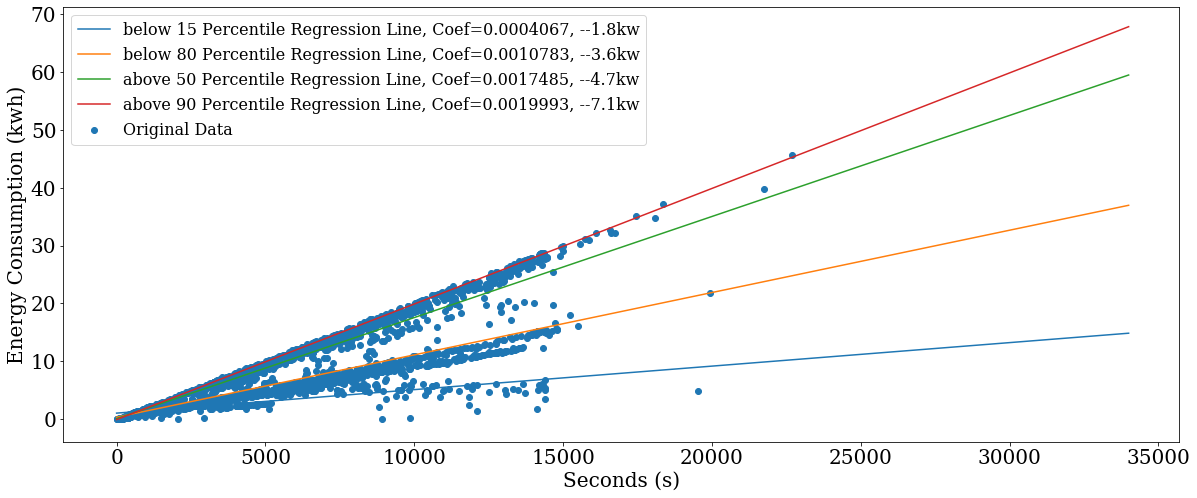

In [12]:
quantile_regression(x_data_chargeTime_copy, y_data_energy_copy, q_list=[15, 80, 50, 90], 
                    loc=[False, False, True, True], comments=["--1.8kw", "--3.6kw", "--4.7kw", "--7.1kw"])

# Idle time

In [13]:
idleTime_list = pd.to_timedelta(cp_df["Total Duration (hh:mm:ss)"]).dt.total_seconds() \
- pd.to_timedelta(cp_df["Charging Time (hh:mm:ss)"]).dt.total_seconds().values
idlegap = 3600

In [14]:
x_data_copy_idle = x_data_chargeTime_copy[np.where(idleTime_list > idlegap)]
y_data_copy_idle = y_data_energy_copy[np.where(idleTime_list > idlegap)]

Coefficients: 0.0019093797063005154, above 90 percentile.
Coefficients: 0.0009768229870724375, below 70 percentile.


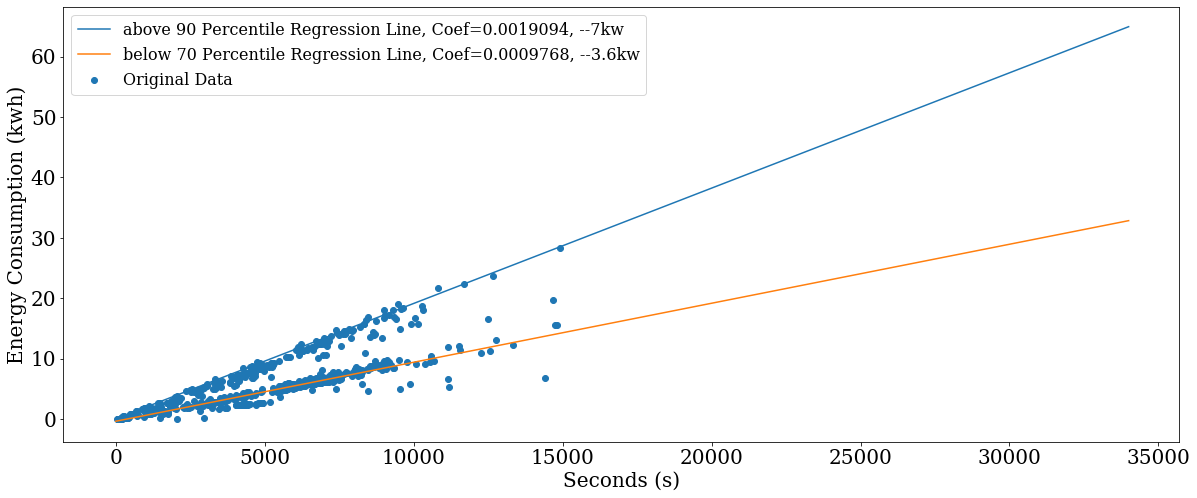

In [15]:
quantile_regression(x_data_copy_idle, y_data_copy_idle, [90, 70], [True, False], ["--7kw", "--3.6kw"])

# Aggregate Demands

In [16]:
csv_file = 'chargpoint_0101_0229_2020_Data.csv'
cp_df = load_chargePoint_data(csv_file, wantzero=True)

dataframe column: 
Index(['Station Name', 'MAC Address', 'Org Name', 'Start Date',
       'Start Time Zone', 'End Date', 'End Time Zone',
       'Transaction Date (Pacific Time)', 'Total Duration (hh:mm:ss)',
       'Charging Time (hh:mm:ss)', 'Energy (kWh)', 'GHG Savings (kg)',
       'Gasoline Savings (gallons)', 'Port Type', 'Port Number', 'Plug Type',
       'EVSE ID', 'Address 1', 'Address 2', 'City', 'State/Province',
       'Postal Code', 'Country', 'Latitude', 'Longitude', 'Currency', 'Fee',
       'Ended By', 'Plug In Event Id', 'Driver Postal Code', 'User ID',
       'Start SOC', 'End SOC', 'County', 'System S/N', 'Model Number'],
      dtype='object')


Fixed 0 NaN values


In [17]:
# Take daylight saving into acount and leave out rows that erroneous
cp_df = cp_df.loc[pd.to_timedelta(cp_df["Total Duration (hh:mm:ss)"]) + dt.timedelta(hours=1) > \
                  pd.to_timedelta(pd.to_datetime(cp_df["End Date"]) - pd.to_datetime(cp_df["Start Date"]))]

In [18]:
cp_df

,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:2010,2020-02-29 23:21:28,2020-03-01 01:43:56,21155551.0,17.229,Level 2,02:22:28,02:22:06
1,0024:B100:0002:12F1,2020-02-29 19:17:28,2020-03-01 00:50:28,20993891.0,21.773,Level 2,05:32:59,05:32:31
2,0024:B100:0002:2010,2020-02-29 21:02:08,2020-02-29 22:55:14,1743601.0,12.007,Level 2,01:53:06,01:45:53
3,0024:B100:0002:1280,2020-02-29 18:52:18,2020-02-29 21:11:57,21005971.0,8.254,Level 2,02:19:39,02:19:15
4,0024:B100:0002:1302,2020-02-29 16:14:12,2020-02-29 20:00:53,21207751.0,14.315,Level 2,03:46:39,03:46:26
5,0024:B100:0002:2342,2020-02-29 16:21:58,2020-02-29 19:40:56,NaN,12.304,Level 2,03:18:57,03:18:38
6,0024:B100:0002:1EFF,2020-02-29 17:03:18,2020-02-29 19:26:34,2625751.0,11.813,Level 2,02:23:15,02:23:03
7,0024:B100:0002:1EFF,2020-02-29 16:53:30,2020-02-29 19:23:32,20901711.0,5.030,Level 2,02:30:02,00:54:08
8,0024:B100:0002:2010,2020-02-29 17:39:14,2020-02-29 18:48:22,453471.0,3.861,Level 2,01:09:11,01:08:55
9,0024:B100:0002:2010,2020-02-29 16:40:33,2020-02-29 18:20:58,4219041.0,5.665,Level 2,01:40:24,01:40:15


## Before aggregating: Utilization, duration, and session length

In [19]:
# extract data and plot data through caluclation
cp_df_2018_2019 = cp_df[pd.to_datetime(cp_df["Start Date"]) > dt.datetime(2019, 1, 15)]

In [20]:
tot_plugInLength = pd.to_timedelta(cp_df_2018_2019["Total Duration (hh:mm:ss)"]).sum()  #total plug in length
tot_chargingLength = pd.to_timedelta(cp_df_2018_2019["Charging Time (hh:mm:ss)"]).sum() #total charging length
actual_charging_rate = tot_chargingLength/tot_plugInLength
utilization_rate = tot_chargingLength.total_seconds()/(dt.datetime(2019,2,16) - dt.datetime(2019,1,16)).total_seconds()/12
print("The charging over parking ratio is: ", actual_charging_rate, ", due to CP is implementing pricing policy.")
print("The utilization rate is: ", utilization_rate, ", from 2019.1.16 to 2019.2.16.")

The charging over parking ratio is:  0.7156741656433305 , due to CP is implementing pricing policy.
The utilization rate is:  0.4327335038331342 , from 2019.1.16 to 2019.2.16.


### Total Duration

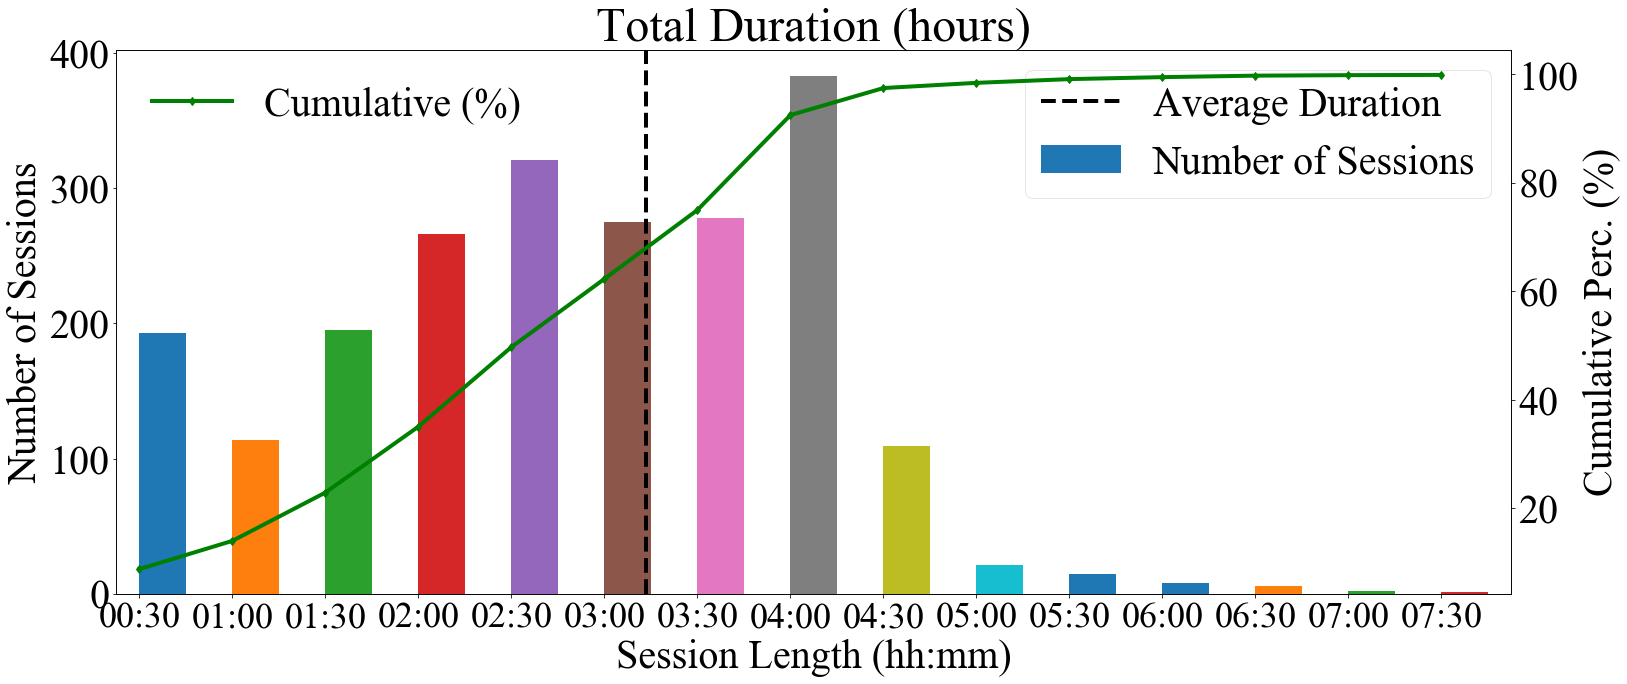

In [21]:
test = np.ceil(pd.to_timedelta(cp_df_2018_2019["Total Duration (hh:mm:ss)"]).dt.total_seconds()/1800).value_counts()
test = test.sort_index(axis=0)
test_df = pd.concat([(100*test.cumsum()/test.sum())[:15], test[:15], sl_df["Session Length (hh:mm)"][1:16]], axis=1)
test_df.columns = ["Cumulative Percentage (%)", "Number of Sessions", "Session Length (hh:mm)"]

# set up plot specs
font = {'family' : 'Times New Roman',
        'size'   : 40}

matplotlib.rc('font', **font)
# average duration length
ave_duration = (test_df["Number of Sessions"]*test_df.index).sum()/test_df["Number of Sessions"].sum()

# plot results
ax = test_df.plot.bar(x="Session Length (hh:mm)", y="Number of Sessions", \
                      figsize=(25, 10), align="edge")
# plot average duration line
ax.axvline(ave_duration, color='k', linestyle='--', linewidth=4, label="Average Duration")
# plot cumulative percentage
ax.set_xticklabels(test_df["Session Length (hh:mm)"], fontsize=36)
ax.set_ylabel("Number of Sessions")
ax.set_title("Total Duration (hours)")

ax2 = test_df.plot.line(x="Session Length (hh:mm)", y="Cumulative Percentage (%)", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True, 
                        label="Cumulative (%)")
ax2.set_ylabel("Cumulative Perc. (%)")
ax.legend(loc="best", framealpha=0.5)
ax2.legend(loc="best", framealpha=0)
# plt.savefig("output_figures/session_total_duration_calc.pdf")

### Charging Duration

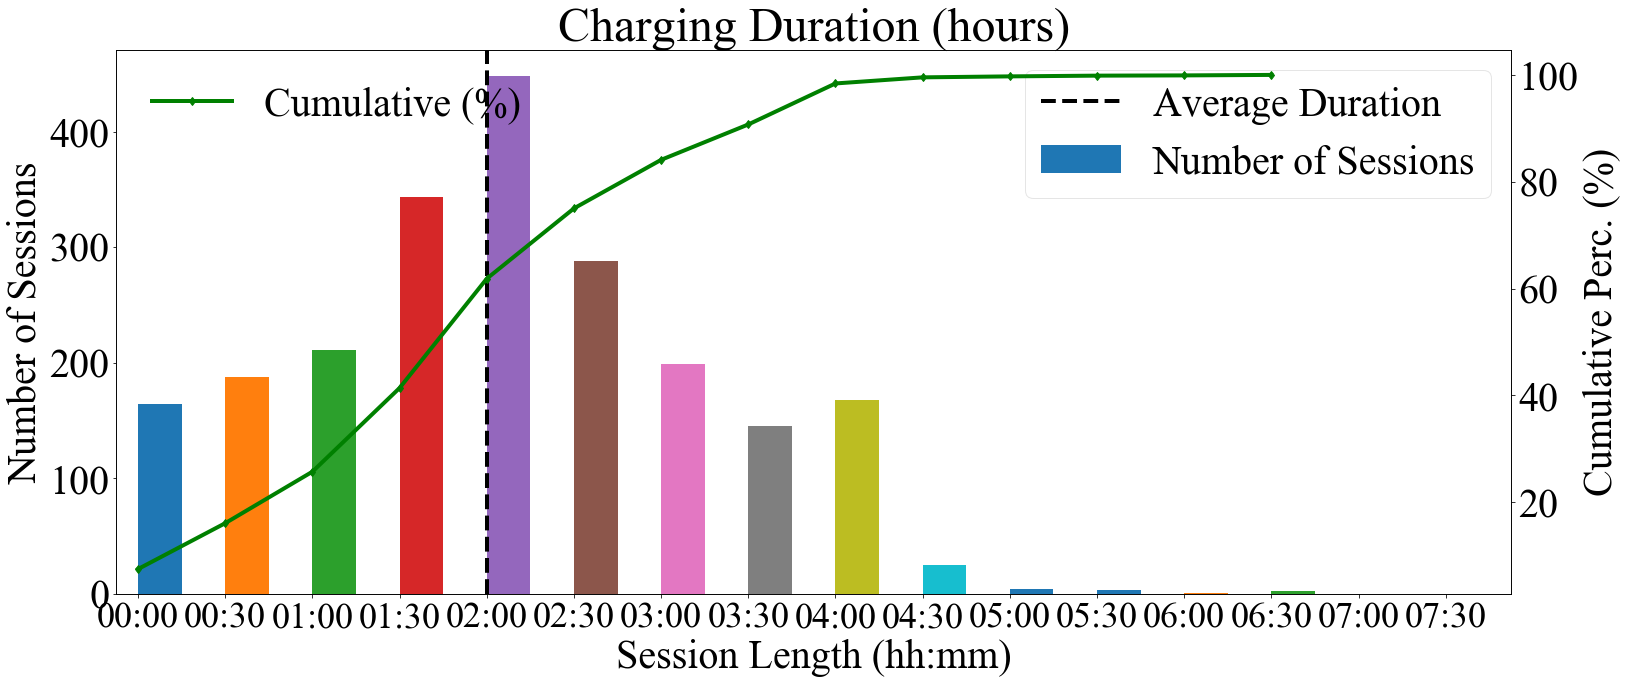

In [22]:
test = np.ceil(pd.to_timedelta(cp_df_2018_2019["Charging Time (hh:mm:ss)"]).dt.total_seconds()/1800).value_counts()
test = test.sort_index(axis=0)
test_df = pd.concat([(100*test.cumsum()/test.sum())[:15], test[:15], sl_df["Session Length (hh:mm)"][:16]], axis=1)
test_df.columns = ["Cumulative Percentage (%)", "Number of Sessions", "Session Length (hh:mm)"]

# set up plot specs
font = {'family' : 'Times New Roman',
        'size'   : 40}

matplotlib.rc('font', **font)
# average duration length
ave_duration = (test_df["Number of Sessions"]*test_df.index).sum()/test_df["Number of Sessions"].sum()

# plot results
ax = test_df.plot.bar(x="Session Length (hh:mm)", y="Number of Sessions", \
                      figsize=(25, 10), align="edge")
# plot average duration line
ax.axvline(ave_duration, color='k', linestyle='--', linewidth=4, label="Average Duration")
# plot cumulative percentage
ax.set_xticklabels(test_df["Session Length (hh:mm)"], fontsize=36)
ax.set_ylabel("Number of Sessions")
ax.set_title("Charging Duration (hours)")

ax2 = test_df.plot.line(x="Session Length (hh:mm)", y="Cumulative Percentage (%)", 
                ax=ax, marker="d", linewidth=4, color="g", secondary_y=True, 
                        label="Cumulative (%)")
ax2.set_ylabel("Cumulative Perc. (%)")
ax.legend(loc="best", framealpha=0.5)
ax2.legend(loc="best", framealpha=0)
# plt.savefig("output_figures/session_charging_duration_calc.pdf")

# Create daily profile

In [23]:
cp_df

,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
0,0024:B100:0002:2010,2020-02-29 23:21:28,2020-03-01 01:43:56,21155551.0,17.229,Level 2,02:22:28,02:22:06
1,0024:B100:0002:12F1,2020-02-29 19:17:28,2020-03-01 00:50:28,20993891.0,21.773,Level 2,05:32:59,05:32:31
2,0024:B100:0002:2010,2020-02-29 21:02:08,2020-02-29 22:55:14,1743601.0,12.007,Level 2,01:53:06,01:45:53
3,0024:B100:0002:1280,2020-02-29 18:52:18,2020-02-29 21:11:57,21005971.0,8.254,Level 2,02:19:39,02:19:15
4,0024:B100:0002:1302,2020-02-29 16:14:12,2020-02-29 20:00:53,21207751.0,14.315,Level 2,03:46:39,03:46:26
5,0024:B100:0002:2342,2020-02-29 16:21:58,2020-02-29 19:40:56,NaN,12.304,Level 2,03:18:57,03:18:38
6,0024:B100:0002:1EFF,2020-02-29 17:03:18,2020-02-29 19:26:34,2625751.0,11.813,Level 2,02:23:15,02:23:03
7,0024:B100:0002:1EFF,2020-02-29 16:53:30,2020-02-29 19:23:32,20901711.0,5.030,Level 2,02:30:02,00:54:08
8,0024:B100:0002:2010,2020-02-29 17:39:14,2020-02-29 18:48:22,453471.0,3.861,Level 2,01:09:11,01:08:55
9,0024:B100:0002:2010,2020-02-29 16:40:33,2020-02-29 18:20:58,4219041.0,5.665,Level 2,01:40:24,01:40:15


In [24]:
def extract_dayData(month, day):
    """
        Extract day utilization data from specified day range
        Note: this function extract data from three years
                so only month and day numbers are needed 
        day_start, day_end - datetime object
    """
    
    years_list = [2019]
    df_tmp = list()
    
    for y in range(len(years_list)):
        
        day_start = dt.datetime(years_list[y], month, day)
        day_end = day_start + dt.timedelta(days=1)

        df_tmp.append(cp_df.loc[(pd.to_datetime(cp_df["Start Date"])>day_start) \
                            & (pd.to_datetime(cp_df["Start Date"])<day_end)])
    
    return pd.concat(df_tmp)

In [25]:
# def datetime2dayidx(starttime, endtime):
#     """
#         Compute tick point index of the day based on the input time
#         Using both datetime objects to determine if EV stays overnight
#         starttime, endtime - datetime object
#     """
# #     if starttime.minute < 30:
# #         starttime_idx = starttime.hour*4 
# #     else:
# #         starttime_idx = starttime.hour*4 + 2
# #     if endtime.minute < 30:
# #         endtime_idx = endtime.hour*4 + 2
# #     else:
# #         endtime_idx = endtime.hour*4 + 4
    
#     if starttime.hour == endtime.hour:
#         starttime_idx = starttime.hour*4
#         endtime_idx = endtime.hour*4+2
#     elif starttime.hour == endtime.hour-1:
#         starttime_idx = starttime.hour*4
#         endtime_idx = endtime.hour*4
#     else:
#         starttime_idx = starttime.hour*4+2
#         endtime_idx = endtime.hour*4
        
#     if starttime.hour > endtime.hour:
#         return starttime_idx, endtime_idx+96
#     else:
#         return starttime_idx, endtime_idx

def datetime2dayidx(starttime, endtime):
    """
        Compute tick point index of the day based on the input time
        Using both datetime objects to determine if EV stays overnight
        starttime, endtime - datetime object
    """
    def datetime2dayidx_helper(time):
        if time.minute < 7.5:
            extra_tick = 0
        elif (time.minute > 7.5) & (time.minute < 22.5):
            extra_tick = 1
        elif (time.minute > 22.5) & (time.minute < 37.5):
            extra_tick = 2
        elif (time.minute > 37.5) & (time.minute < 52.5):
            extra_tick = 3
        else:
            extra_tick = 4
        return extra_tick
    
    extra_tick_start = datetime2dayidx_helper(starttime)
    extra_tick_end = datetime2dayidx_helper(endtime)
    
    starttime_idx = starttime.hour*4 + extra_tick_start
    endtime_idx = endtime.hour*4 + extra_tick_end
    if starttime.hour > endtime.hour:
        return starttime_idx, endtime_idx+96
    else:
        return starttime_idx, endtime_idx

# def datetime2dayidx(starttime, endtime):
#     """
#         Compute tick point index of the day based on the input time
#         Using both datetime objects to determine if EV stays overnight
#         starttime, endtime - datetime object
#     """
# #     if starttime.minute < 30:
# #         starttime_idx = starttime.hour*4 
# #     else:
# #         starttime_idx = starttime.hour*4 + 2
# #     if endtime.minute < 30:
# #         endtime_idx = endtime.hour*4 + 2
# #     else:
# #         endtime_idx = endtime.hour*4 + 4
#     starttime_idx = starttime.hour*4 
#     endtime_idx = endtime.hour*4 + 4
        
#     if starttime.hour > endtime.hour:
#         return starttime_idx, endtime_idx+96
#     else:
#         return starttime_idx, endtime_idx



# Visualization for demands based on one day


In [36]:
dayofInterest_start = dt.datetime(2020, 2, 1, 0, 0, 0)
dayofInterest_end = dt.datetime(2020, 2, 2, 0, 0, 0)
cp_df_baseline = cp_df[pd.to_datetime(cp_df.loc[:, "Start Date"]) > dayofInterest_start]
cp_df_baseline = cp_df_baseline[pd.to_datetime(cp_df.loc[:, "End Date"]) < dayofInterest_end]
cp_df_baseline = cp_df_baseline.sort_values(by=["Start Date"])
cp_df_baseline

/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,MAC Address,Start Date,End Date,User ID,Energy (kWh),Port Type,Total Duration (hh:mm:ss),Charging Time (hh:mm:ss)
1154,0024:B100:0002:1302,2020-02-01 01:16:45,2020-02-01 02:20:29,20984591.0,4.040,Level 2,01:03:43,01:03:36
1150,0024:B100:0002:1EFF,2020-02-01 07:20:20,2020-02-01 11:21:07,21100071.0,15.484,Level 2,04:00:47,04:00:35
1151,0024:B100:0002:2010,2020-02-01 07:23:31,2020-02-01 10:37:30,648859.0,8.778,Level 2,03:13:59,02:34:16
1152,0024:B100:0002:1EFF,2020-02-01 09:18:41,2020-02-01 10:27:59,20901711.0,7.971,Level 2,01:09:22,01:09:05
1149,0024:B100:0002:1EFF,2020-02-01 10:37:34,2020-02-01 12:34:59,379067.0,4.937,Level 2,01:57:25,01:34:05
1148,0024:B100:0002:2010,2020-02-01 12:12:31,2020-02-01 13:08:16,1260731.0,6.005,Level 2,00:55:49,00:55:17
1145,0024:B100:0002:1302,2020-02-01 12:13:12,2020-02-01 15:36:44,1782891.0,12.939,Level 2,03:23:32,01:51:45
1147,0024:B100:0002:2342,2020-02-01 12:32:44,2020-02-01 13:27:59,20381071.0,6.431,Level 2,00:55:14,00:55:00
1144,0024:B100:0002:1302,2020-02-01 12:53:10,2020-02-01 16:33:28,20170031.0,0.021,Level 2,03:40:17,00:01:14
1146,0024:B100:0002:2010,2020-02-01 14:12:00,2020-02-01 15:21:33,319415.0,3.833,Level 2,01:09:32,01:09:20


([<matplotlib.axis.XTick at 0x7f8e97bc74e0>,
 <a list of 12 Text xticklabel objects>)

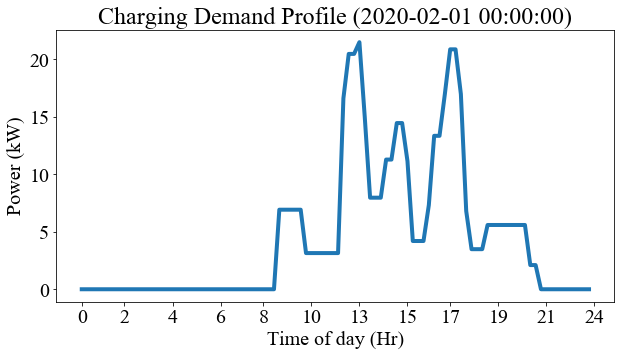

In [46]:
powProf_baseline = np.zeros(96)
for act_idx in cp_df_baseline.index:
    # Identify start time and end time
    start_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "Start Date"])
    end_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "End Date"])
    if start_date.hour > 7:
        if (end_date.hour < 22) and (end_date.day == start_date.day):
            
            # Ensure no over night staying
            act_startTime, act_endTime = datetime2dayidx(start_date, end_date)
            # Generate power consumption of time
            act_charDuration = pd.to_timedelta(cp_df_baseline.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/3600
            
            if act_charDuration != 0.0:
                # Ensure charging activity
                act_charRate = cp_df_baseline.loc[act_idx, "Energy (kWh)"] / act_charDuration
                act_powerTemp = np.zeros(96)
                np.put(act_powerTemp, np.arange(act_startTime, act_endTime), act_charRate)
                powProf_baseline += act_powerTemp

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,5))
plt.plot(range(96), powProf_baseline, linewidth=4)
plt.title("Charging Demand Profile ({})".format(dayofInterest_start))
plt.xlabel("Time of day (Hr)")
plt.ylabel("Power (kW)")
plt.xticks(np.linspace(0, 96, 12, dtype="int"), np.linspace(0, 24, 12, dtype="int"))

# plt.savefig("../visualization/vis_chargingProfile.pdf")

# Visualization for demands based on specified days

/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



([<matplotlib.axis.XTick at 0x7f8e98a492e8>,
 <a list of 12 Text xticklabel objects>)

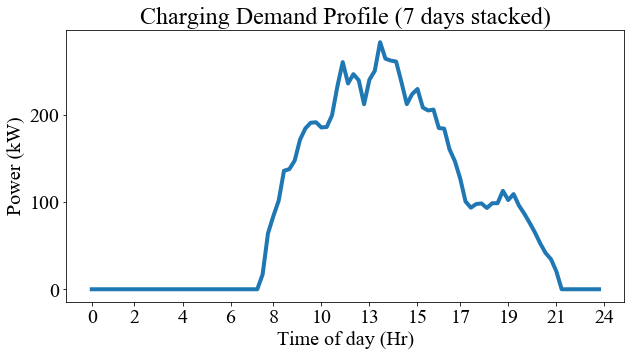

In [47]:
powProf_baseline = np.zeros(96)

for day_id in range(7):
    dayofInterest_start = dt.datetime(2020, 2, 16+day_id, 0, 0, 0)
    dayofInterest_end = dt.datetime(2020, 2, 17+day_id, 0, 0, 0)
    cp_df_baseline = cp_df[pd.to_datetime(cp_df.loc[:, "Start Date"]) > dayofInterest_start]
    cp_df_baseline = cp_df_baseline[pd.to_datetime(cp_df.loc[:, "End Date"]) < dayofInterest_end]
    cp_df_baseline = cp_df_baseline.sort_values(by=["Start Date"])
    for act_idx in cp_df_baseline.index:
        # Identify start time and end time
        start_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "Start Date"])
        end_date = pd.to_datetime(cp_df_baseline.loc[act_idx, "End Date"])
        if start_date.hour > 7:
            if (end_date.hour < 22) and (end_date.day == start_date.day):

                # Ensure no over night staying
                act_startTime, act_endTime = datetime2dayidx(start_date, end_date)
                # Generate power consumption of time
                act_charDuration = pd.to_timedelta(cp_df_baseline.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/3600

                if act_charDuration != 0.0:
                    # Ensure charging activity
                    act_charRate = cp_df_baseline.loc[act_idx, "Energy (kWh)"] / act_charDuration
                    act_powerTemp = np.zeros(96)
                    np.put(act_powerTemp, np.arange(act_startTime, act_endTime), act_charRate)
                    powProf_baseline += act_powerTemp

font = {'family' : 'Times New Roman',
        'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=(10,5))
plt.plot(range(96), powProf_baseline, linewidth=4)
plt.title("Charging Demand Profile (7 days stacked)")
plt.xlabel("Time of day (Hr)")
plt.ylabel("Power (kW)")
plt.xticks(np.linspace(0, 96, 12, dtype="int"), np.linspace(0, 24, 12, dtype="int"))

# plt.savefig("../visualization/vis_chargingProfile.pdf")

# Function to extract data

In [48]:
def ee227_extrData(cp_df, ee227c_df):
    """
    cp_df is the raw dataframe trying to extract data out of
    ee227c_df is the desired dateframe to put into
    """
    for act_idx in cp_df.index:

        # check if end time is before specified
        end_hr = 22 # station shuts down at 10pm
        start_hr = 7 # station starts at 7am
        
        act_end_time = dt.datetime.strptime(cp_df.loc[act_idx, "End Date"], "%Y-%m-%d %H:%M:%S")
        act_arr_time = dt.datetime.strptime(cp_df.loc[act_idx, "Start Date"], "%Y-%m-%d %H:%M:%S")

        if act_end_time < dt.datetime(act_end_time.year, act_end_time.month, act_end_time.day, end_hr) \
        and act_arr_time > dt.datetime(act_end_time.year, act_end_time.month, act_end_time.day, start_hr):

            act_tot_duration = (act_end_time - act_arr_time).total_seconds()/60/60

            act_arr_time = act_arr_time.hour + act_arr_time.minute/60 # convert arrival time to format

            # Charging duration and charging rate
            e_delivered = cp_df.loc[act_idx, "Energy (kWh)"] 
            act_char_dur = pd.to_timedelta(cp_df.loc[act_idx, "Charging Time (hh:mm:ss)"]).total_seconds()/60/60
            # Determine battery size
            charging_rate = e_delivered/act_char_dur
#             if e_delivered > 40:
            if False:
                # assign to 7.2 kW catagory
                battery_cap = 75 # battery_cap is used to cap the energy upper bound
                act_power_max = 7.2
#             elif charging_rate > 4.2:
            elif False:
                # assign to 7.2 kW catagory
                battery_cap = large_batSize # battery_cap is used to cap the energy upper bound
                act_power_max = 7.2
            else:
                # assign to 3.6 kW catagory
                battery_cap = small_batSize    
                act_power_max = 7.2
                if battery_cap < e_delivered:
                    battery_cap = large_batSize

            act_soc_need = e_delivered/battery_cap
            if act_soc_need > 1:
                print("Needed SOC greater than 1.")
                pdb.set_trace()
            act_soc_init = 0.95 - act_soc_need
            if act_soc_init < 0:
                act_soc_init = 0

            act_overstay_dur = act_tot_duration - act_char_dur
            if act_tot_duration <  act_overstay_dur:
                
                print("total duration: {}".format(act_tot_duration))
                print("Charging duration: {} \n".format(act_char_dur))

            df_temp = pd.DataFrame([[act_arr_time, act_soc_init, 0.95, battery_cap, 
                                     act_char_dur, act_overstay_dur, act_power_max]], 
                                   columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                            "duration", "overstay_duration", "power_max"])
            ee227c_df = ee227c_df.append(df_temp)
    return ee227c_df

# Extract data for baseline one day

In [49]:
ee227c_df_base = pd.DataFrame(columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                        "duration", "overstay_duration", "power_max"])
# Extract battery size
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
large_batSize = ev_sales_df.loc["7.2SUM","Battery (kWh)"]
small_batSize = ev_sales_df.loc["3.6SUM","Battery (kWh)"]

ee227c_df_base = ee227_extrData(cp_df_baseline, ee227c_df_base)

# Verify if duration can satisfy the need
act_unqualify_numb = ((ee227c_df_base.loc[:, "soc_need"] * ee227c_df_base.loc[:, "batt_cap"] / ee227c_df_base.loc[:, "power_max"]) > ee227c_df_base.loc[:, "duration"]).sum()
print("Number of unqualified activities are {}.".format(act_unqualify_numb))
ee227c_df_base = ee227c_df_base[(ee227c_df_base.loc[:, "soc_need"] * ee227c_df_base.loc[:, "batt_cap"] / ee227c_df_base.loc[:, "power_max"]) < ee227c_df_base.loc[:, "duration"]]

# Sort dataframe based on event time order and filter duration
ee227c_df_base = ee227c_df_base.sort_values(by=["arr_time"])
ee227c_df_base = ee227c_df_base[ee227c_df_base["duration"] > 0.3]
# ee227c_df_base.to_csv("../real_act_data_1day.csv")

Number of unqualified activities are 18.


/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in double_scalars



In [50]:
ee227c_df_base

,arr_time,soc_init,soc_need,batt_cap,duration,overstay_duration,power_max
0,9.800000,0.254440,0.95,11.77469,2.157778,0.002778,7.2
0,10.366667,0.451218,0.95,11.77469,1.860833,1.400278,7.2
0,14.816667,0.056473,0.95,11.77469,2.936944,1.058611,7.2
0,18.100000,0.110233,0.95,11.77469,2.584444,0.005556,7.2


# Extract data across couple days

In [51]:
# for simplicity as well as prior consensus, time discretization is 15 min.
# Initialize dataframe
ee227c_df_grand = pd.DataFrame(columns=["arr_time", "soc_init", "soc_need", "batt_cap", 
                                        "duration", "overstay_duration", "power_max"])

# Extract battery size
ev_sales_df = pd.read_excel("ev_historicalSales.xlsx",index_col=0)
large_batSize = ev_sales_df.loc["7.2SUM","Battery (kWh)"]
small_batSize = ev_sales_df.loc["3.6SUM","Battery (kWh)"]

ee227c_df_grand = ee227_extrData(cp_df.dropna(), ee227c_df_grand)

/Users/janton/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning:

invalid value encountered in double_scalars



In [52]:
# Verify if duration can satisfy the need
act_unqualify_numb = ((ee227c_df_grand.loc[:, "soc_need"] * ee227c_df_grand.loc[:, "batt_cap"] / ee227c_df_grand.loc[:, "power_max"]) > ee227c_df_grand.loc[:, "duration"]).sum()
print("Number of unqualified activities are {}.".format(act_unqualify_numb))
ee227c_df_grand = ee227c_df_grand[(ee227c_df_grand.loc[:, "soc_need"] * ee227c_df_grand.loc[:, "batt_cap"] / ee227c_df_grand.loc[:, "power_max"]) < ee227c_df_grand.loc[:, "duration"]]
# Sort dataframe based on event time order and filter duration
ee227c_df_grand = ee227c_df_grand.sort_values(by=["arr_time"])
ee227c_df_grand = ee227c_df_grand[ee227c_df_grand["duration"] > 0.1]
ee227c_df_grand.to_csv("../real_act_data.csv")

Number of unqualified activities are 1314.


In [53]:
ee227c_df_grand

,arr_time,soc_init,soc_need,batt_cap,duration,overstay_duration,power_max
0,7.066667,0.000000,0.95,11.77469,1.686944,0.005278,7.2
0,7.100000,0.038554,0.95,11.77469,1.828056,0.005000,7.2
0,7.116667,0.438139,0.95,11.77469,2.238611,0.013056,7.2
0,7.166667,0.090275,0.95,11.77469,1.881667,2.044722,7.2
0,7.216667,0.046961,0.95,11.77469,1.959167,1.601667,7.2
0,7.250000,0.043649,0.95,11.77469,1.564722,0.004722,7.2
0,7.266667,0.202125,0.95,11.77469,2.651667,0.002222,7.2
0,7.316667,0.436186,0.95,11.77469,1.971389,0.039722,7.2
0,7.316667,0.385059,0.95,11.77469,2.504444,0.019167,7.2
0,7.316667,0.228113,0.95,11.77469,2.558333,0.005833,7.2
